GIF guardado en: graphs_dashboard.gif


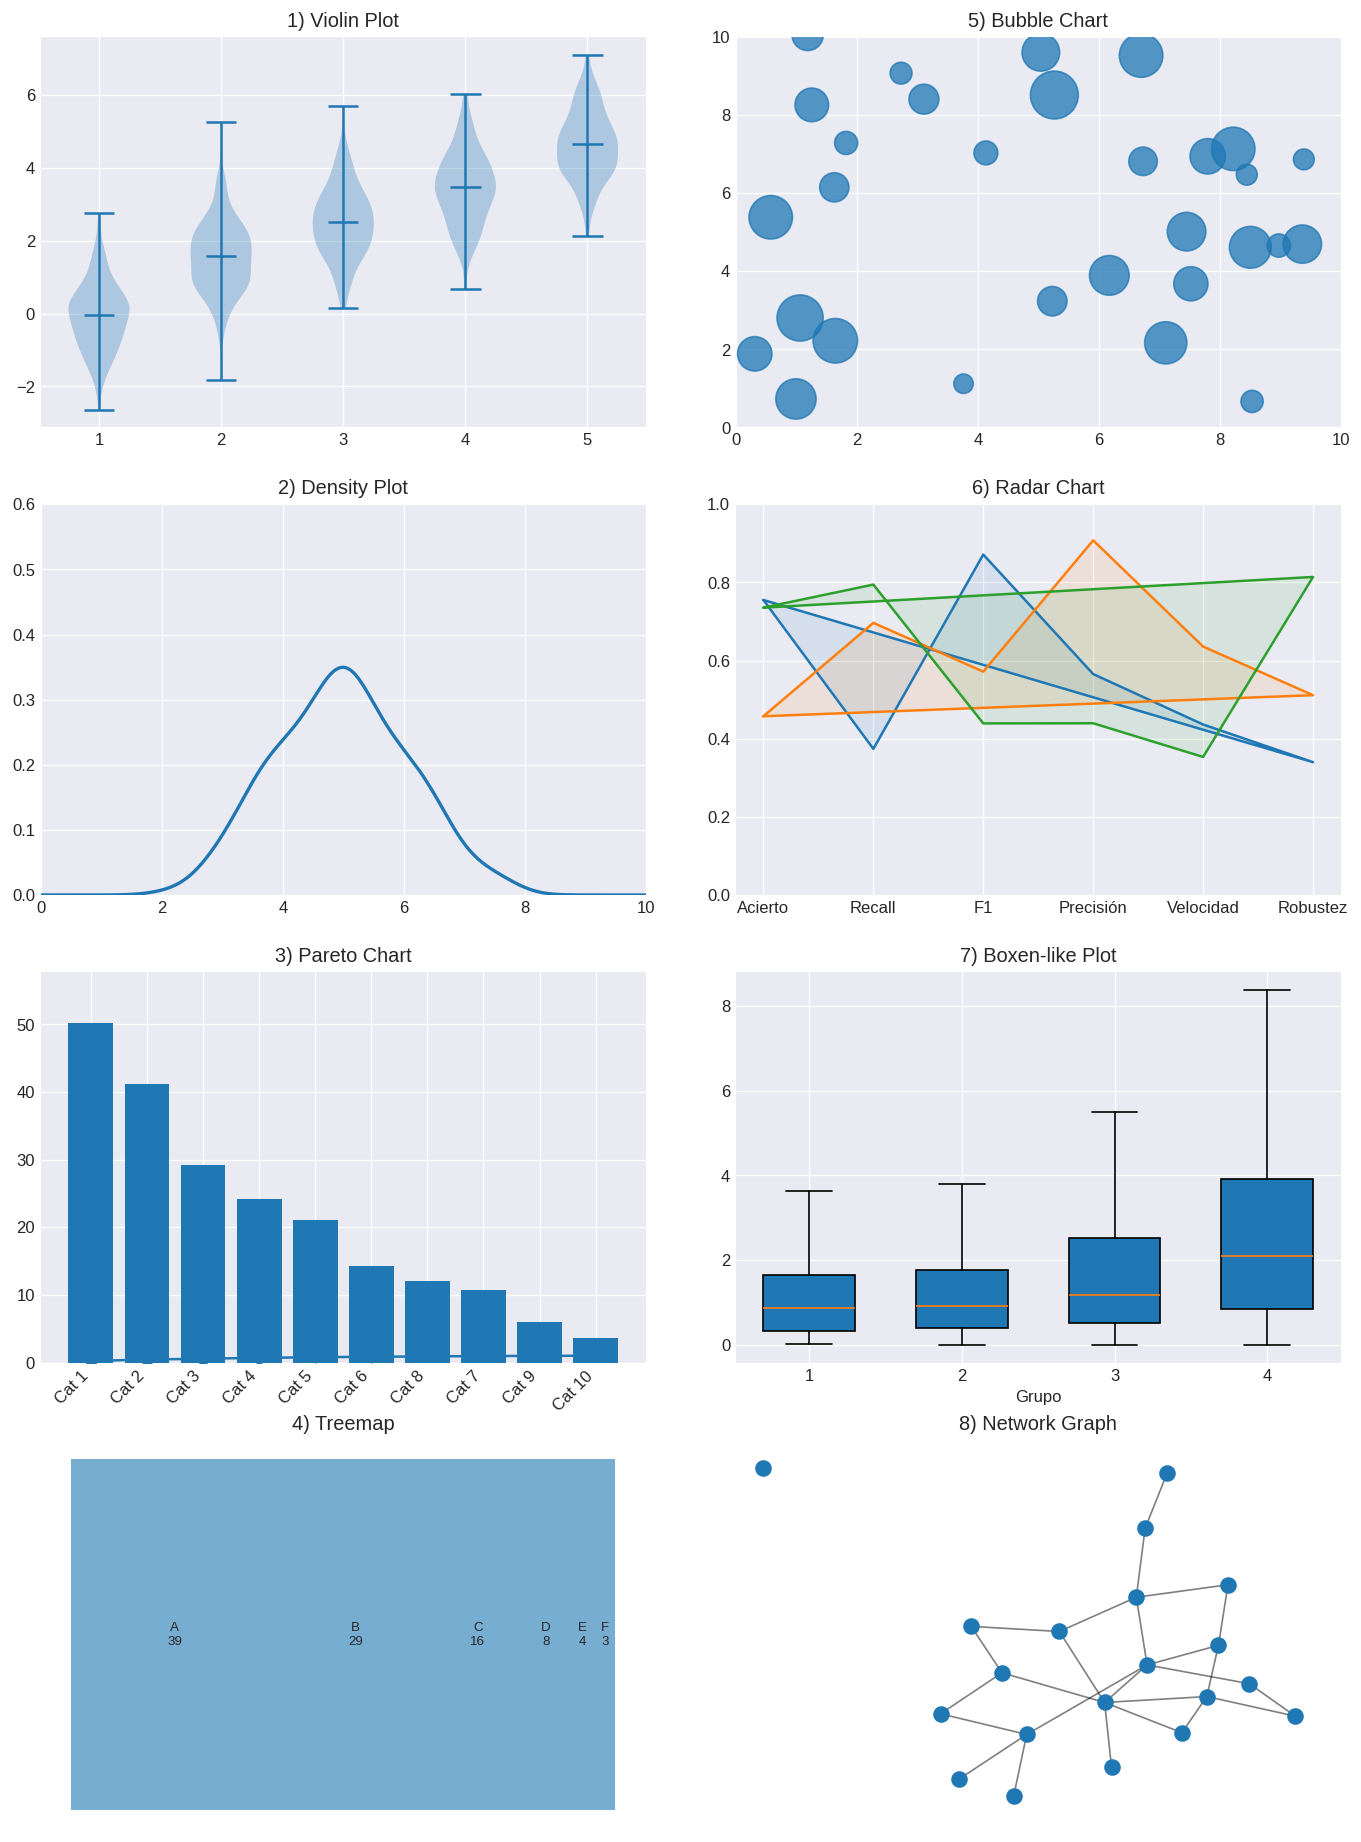

In [ ]:
# -------------------------------
# GIF animado: 8 gráficos en una página
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde
import networkx as nx

# Intentar importar squarify para treemap; si no, fallback
try:
    import squarify
    _HAS_SQUARIFY = True
except Exception:
    _HAS_SQUARIFY = False

import os
plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

# Parámetros
N = 200
frames = 80
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
plt.tight_layout(pad=3.0)

# Ejes (izq columna 0, derecha columna 1)
ax_violin = axes[0,0]
ax_density = axes[1,0]
ax_pareto = axes[2,0]
ax_treemap = axes[3,0]

ax_bubble = axes[0,1]
ax_radar = axes[1,1]
ax_boxen = axes[2,1]
ax_network = axes[3,1]

# ---------------------------
# Datos base
# ---------------------------
# 1) Violin
groups = 5
base_data = [np.random.normal(loc=i*1.2, scale=1.0, size=N) for i in range(groups)]

# 2) Density
density_N = N

# 3) Pareto
cats = [f"Cat {i}" for i in range(1,11)]
base_counts = np.array([50,40,30,25,20,15,12,10,8,5])

# 4) Treemap
treemap_labels = ["A","B","C","D","E","F"]
treemap_values = np.array([40, 25, 15, 10, 6, 4])

# 5) Bubble
bubble_x = np.random.uniform(0,10,30)
bubble_y = np.random.uniform(0,10,30)
bubble_size = np.random.uniform(30,800,30)

# 6) Radar
radar_categories = ["Acierto","Recall","F1","Precisión","Velocidad","Robustez"]
radar_vals_base = np.random.uniform(0.3, 0.9, (3, len(radar_categories)))  # 3 modelos

# 7) Boxen-like
boxen_groups = 4
boxen_data_base = [np.random.exponential(scale=1.0 + i*0.5, size=500) for i in range(boxen_groups)]

# 8) Network
G = nx.erdos_renyi_graph(20, 0.12, seed=1)
pos0 = nx.spring_layout(G, seed=1)

# ---------------------------
# Helper: draw treemap
# ---------------------------
def draw_treemap(vals, labels, ax):
    ax.clear()
    ax.set_title("4) Treemap")
    ax.axis('off')
    if _HAS_SQUARIFY:
        squarify.plot(sizes=vals, label=[f"{l}\n{int(v)}" for l,v in zip(labels, vals)], ax=ax, pad=True)
    else:
        total = vals.sum()
        x0 = 0.05
        y0 = 0.05
        w = 0.9
        h = 0.9
        current_x = x0
        for v,lab in zip(vals, labels):
            width = w * (v/total)
            rect = plt.Rectangle((current_x, y0), width, h, fill=True, alpha=0.6)
            ax.add_patch(rect)
            ax.text(current_x + width/2, y0 + h/2, f"{lab}\n{int(v)}", va='center', ha='center', fontsize=8)
            current_x += width

# ---------------------------
# Inicialización visual
# ---------------------------
ax_violin.set_title("1) Violin Plot")
ax_density.set_title("2) Density Plot")
ax_pareto.set_title("3) Pareto Chart")
ax_treemap.set_title("4) Treemap")
ax_bubble.set_title("5) Bubble Chart")
ax_radar.set_title("6) Radar Chart")
ax_boxen.set_title("7) Boxen-like Plot")
ax_network.set_title("8) Network Graph")

line_density, = ax_density.plot([], [], lw=2)
ax_density.set_xlim(0,10)
ax_density.set_ylim(0,0.6)
ax_bubble.set_xlim(0,10)
ax_bubble.set_ylim(0,10)
ax_bubble.set_xlabel("X")
ax_bubble.set_ylabel("Y")

angles = np.linspace(0, 2*np.pi, len(radar_categories), endpoint=False).tolist()
angles += angles[:1]  # cerrar círculo

# ---------------------------
# Función de actualización
# ---------------------------
def update(frame):
    t = frame / frames

    # 1) Violin
    new_data = [d + np.sin(2*np.pi*(t + i/5))*0.3 + np.random.normal(scale=0.05, size=d.shape)
                for i,d in enumerate(base_data)]
    ax_violin.clear()
    ax_violin.set_title("1) Violin Plot")
    ax_violin.violinplot(new_data, showmeans=False, showmedians=True)

    # 2) Density
    loc = 5 + np.sin(2*np.pi*t)
    scale = 0.8 + 0.3*np.cos(2*np.pi*t)
    sample = np.random.normal(loc=loc, scale=scale, size=density_N)
    kde = gaussian_kde(sample)
    xs = np.linspace(0,10,300)
    ys = kde(xs)
    line_density.set_data(xs, ys)
    ax_density.relim()
    ax_density.autoscale_view(True,True,True)
    ax_density.set_title("2) Density Plot")

    # 3) Pareto
    noise = np.random.normal(scale=2.0, size=base_counts.shape)
    counts = np.clip(base_counts + noise * (1 + 0.5*np.sin(2*np.pi*t)), a_min=1, a_max=None)
    sorted_idx = np.argsort(-counts)
    sorted_counts = counts[sorted_idx]
    sorted_cats = np.array(cats)[sorted_idx]
    ax_pareto.clear()
    ax_pareto.bar(sorted_cats, sorted_counts)
    cum = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    ax_pareto.plot(sorted_cats, cum, marker='o')
    ax_pareto.set_ylim(0, max(sorted_counts)*1.15)
    ax_pareto.set_title("3) Pareto Chart")
    ax_pareto.set_xticks(range(len(sorted_cats)))
    ax_pareto.set_xticklabels(sorted_cats, rotation=45, ha='right')

    # 4) Treemap
    perturb = treemap_values * (1 + 0.2*np.sin(2*np.pi*(t + np.arange(len(treemap_values))/5)))
    draw_treemap(np.clip(perturb, 1, None), treemap_labels, ax_treemap)

    # 5) Bubble
    bx = bubble_x + 0.4*np.sin(2*np.pi*(t + np.arange(len(bubble_x))/10))
    by = bubble_y + 0.4*np.cos(2*np.pi*(t + np.arange(len(bubble_y))/12))
    bsize = bubble_size * (0.6 + 0.4*(1 + 0.5*np.sin(2*np.pi*(t + np.arange(len(bubble_size))/7))))
    ax_bubble.clear()
    ax_bubble.set_title("5) Bubble Chart")
    ax_bubble.scatter(bx, by, s=bsize, alpha=0.75)
    ax_bubble.set_xlim(0,10)
    ax_bubble.set_ylim(0,10)

    # 6) Radar
    ax_radar.clear()
    ax_radar.set_title("6) Radar Chart")
    for i in range(radar_vals_base.shape[0]):
        vals = radar_vals_base[i] * (1 + 0.15*np.sin(2*np.pi*(t + i*0.2)))
        vals = np.concatenate([vals, vals[:1]])
        ax_radar.plot(angles, vals)
        ax_radar.fill(angles, vals, alpha=0.1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(radar_categories)
    ax_radar.set_ylim(0,1)

    # 7) Boxen-like
    ax_boxen.clear()
    ax_boxen.set_title("7) Boxen-like Plot")
    for i, d in enumerate(boxen_data_base, start=1):
        d_shift = d * (1 + 0.2*np.sin(2*np.pi*(t + i*0.3)))
        ax_boxen.boxplot(d_shift, positions=[i], widths=0.6, patch_artist=True, manage_ticks=False, showfliers=False)
    ax_boxen.set_xticks(range(1, boxen_groups+1))
    ax_boxen.set_xlabel("Grupo")

    # 8) Network
    ax_network.clear()
    ax_network.set_title("8) Network Graph")
    pos = nx.spring_layout(G, pos=pos0, iterations=5)
    nx.draw_networkx_edges(G, pos=pos, ax=ax_network, alpha=0.5)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax_network, node_size=80)
    ax_network.set_axis_off()

    return []

# ---------------------------
# Crear animación y guardar GIF
# ---------------------------
anim = FuncAnimation(fig, update, frames=frames, interval=80, blit=False)
out_path = "graphs_dashboard.gif"  # se guarda en directorio actual
writer = PillowWriter(fps=12)
anim.save(out_path, writer=writer)
print(f"GIF guardado en: {out_path}")

# Mostrar último frame
update(frames-1)
plt.show()


GIF guardado en: graphs_dashboard.gif


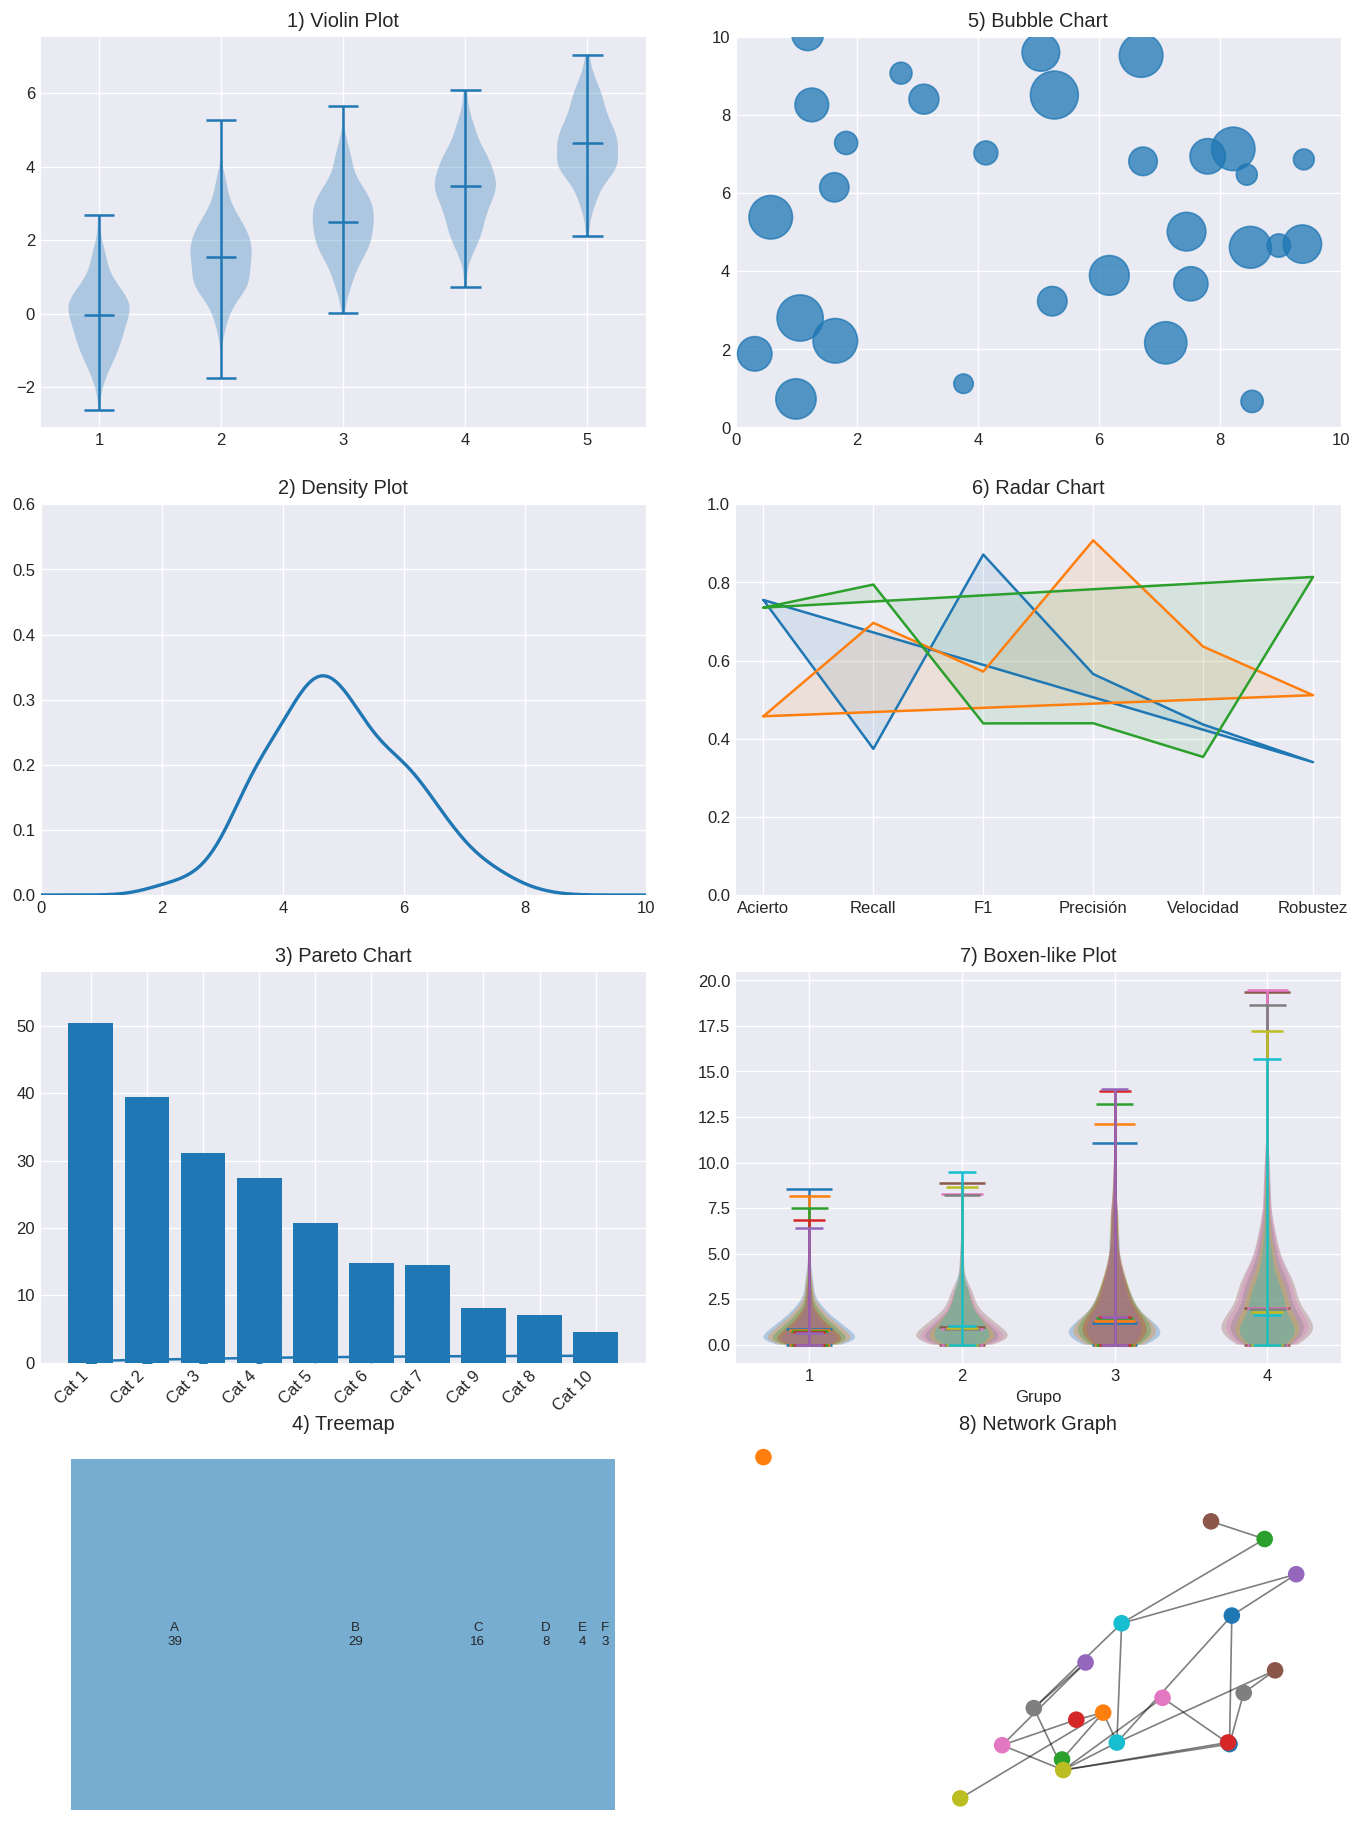

In [ ]:
# -------------------------------
# GIF animado: 8 gráficos en una página
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde
import networkx as nx

# Intentar importar squarify para treemap; si no, fallback
try:
    import squarify
    _HAS_SQUARIFY = True
except Exception:
    _HAS_SQUARIFY = False

plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

# Parámetros
N = 200
frames = 80
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
plt.tight_layout(pad=3.0)

# Ejes
ax_violin = axes[0,0]
ax_density = axes[1,0]
ax_pareto = axes[2,0]
ax_treemap = axes[3,0]
ax_bubble = axes[0,1]
ax_radar = axes[1,1]
ax_boxen = axes[2,1]
ax_network = axes[3,1]

# ---------------------------
# Datos base
# ---------------------------
# 1) Violin
groups = 5
base_data = [np.random.normal(loc=i*1.2, scale=1.0, size=N) for i in range(groups)]

# 2) Density
density_N = N

# 3) Pareto
cats = [f"Cat {i}" for i in range(1,11)]
base_counts = np.array([50,40,30,25,20,15,12,10,8,5])

# 4) Treemap
treemap_labels = ["A","B","C","D","E","F"]
treemap_values = np.array([40, 25, 15, 10, 6, 4])

# 5) Bubble
bubble_x = np.random.uniform(0,10,30)
bubble_y = np.random.uniform(0,10,30)
bubble_size = np.random.uniform(30,800,30)

# 6) Radar
radar_categories = ["Acierto","Recall","F1","Precisión","Velocidad","Robustez"]
radar_vals_base = np.random.uniform(0.3, 0.9, (3, len(radar_categories)))  # 3 modelos

# 7) Boxen-like
boxen_groups = 4
boxen_data_base = [np.random.exponential(scale=1.0 + i*0.5, size=500) for i in range(boxen_groups)]

# 8) Network
G = nx.erdos_renyi_graph(20, 0.12, seed=1)
pos0 = nx.spring_layout(G, seed=1)

# ---------------------------
# Helper: draw treemap
# ---------------------------
def draw_treemap(vals, labels, ax):
    ax.clear()
    ax.set_title("4) Treemap")
    ax.axis('off')
    if _HAS_SQUARIFY:
        squarify.plot(sizes=vals, label=[f"{l}\n{int(v)}" for l,v in zip(labels, vals)], ax=ax, pad=True)
    else:
        total = vals.sum()
        x0 = 0.05
        y0 = 0.05
        w = 0.9
        h = 0.9
        current_x = x0
        for v,lab in zip(vals, labels):
            width = w * (v/total)
            rect = plt.Rectangle((current_x, y0), width, h, fill=True, alpha=0.6)
            ax.add_patch(rect)
            ax.text(current_x + width/2, y0 + h/2, f"{lab}\n{int(v)}", va='center', ha='center', fontsize=8)
            current_x += width

# ---------------------------
# Inicialización visual
# ---------------------------
ax_violin.set_title("1) Violin Plot")
ax_density.set_title("2) Density Plot")
ax_pareto.set_title("3) Pareto Chart")
ax_treemap.set_title("4) Treemap")
ax_bubble.set_title("5) Bubble Chart")
ax_radar.set_title("6) Radar Chart")
ax_boxen.set_title("7) Boxen-like Plot")
ax_network.set_title("8) Network Graph")

line_density, = ax_density.plot([], [], lw=2)
ax_density.set_xlim(0,10)
ax_density.set_ylim(0,0.6)
ax_bubble.set_xlim(0,10)
ax_bubble.set_ylim(0,10)
ax_bubble.set_xlabel("X")
ax_bubble.set_ylabel("Y")
angles = np.linspace(0, 2*np.pi, len(radar_categories), endpoint=False).tolist()
angles += angles[:1]

# ---------------------------
# Función de actualización
# ---------------------------
def update(frame):
    t = frame / frames

    # 1) Violin
    new_data = [d + np.sin(2*np.pi*(t + i/5))*0.3 + np.random.normal(scale=0.05, size=d.shape)
                for i,d in enumerate(base_data)]
    ax_violin.clear()
    ax_violin.set_title("1) Violin Plot")
    ax_violin.violinplot(new_data, showmeans=False, showmedians=True)

    # 2) Density
    loc = 5 + np.sin(2*np.pi*t)
    scale = 0.8 + 0.3*np.cos(2*np.pi*t)
    sample = np.random.normal(loc=loc, scale=scale, size=density_N)
    kde = gaussian_kde(sample)
    xs = np.linspace(0,10,300)
    ys = kde(xs)
    line_density.set_data(xs, ys)
    ax_density.relim()
    ax_density.autoscale_view(True,True,True)
    ax_density.set_title("2) Density Plot")

    # 3) Pareto
    noise = np.random.normal(scale=2.0, size=base_counts.shape)
    counts = np.clip(base_counts + noise * (1 + 0.5*np.sin(2*np.pi*t)), a_min=1, a_max=None)
    sorted_idx = np.argsort(-counts)
    sorted_counts = counts[sorted_idx]
    sorted_cats = np.array(cats)[sorted_idx]
    ax_pareto.clear()
    ax_pareto.bar(sorted_cats, sorted_counts)
    cum = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    ax_pareto.plot(sorted_cats, cum, marker='o')
    ax_pareto.set_ylim(0, max(sorted_counts)*1.15)
    ax_pareto.set_title("3) Pareto Chart")
    ax_pareto.set_xticks(range(len(sorted_cats)))
    ax_pareto.set_xticklabels(sorted_cats, rotation=45, ha='right')

    # 4) Treemap
    perturb = treemap_values * (1 + 0.2*np.sin(2*np.pi*(t + np.arange(len(treemap_values))/5)))
    draw_treemap(np.clip(perturb, 1, None), treemap_labels, ax_treemap)

    # 5) Bubble
    bx = bubble_x + 0.4*np.sin(2*np.pi*(t + np.arange(len(bubble_x))/10))
    by = bubble_y + 0.4*np.cos(2*np.pi*(t + np.arange(len(bubble_y))/12))
    bsize = bubble_size * (0.6 + 0.4*(1 + 0.5*np.sin(2*np.pi*(t + np.arange(len(bubble_size))/7))))
    ax_bubble.clear()
    ax_bubble.set_title("5) Bubble Chart")
    ax_bubble.scatter(bx, by, s=bsize, alpha=0.75)
    ax_bubble.set_xlim(0,10)
    ax_bubble.set_ylim(0,10)

    # 6) Radar
    ax_radar.clear()
    ax_radar.set_title("6) Radar Chart")
    for i in range(radar_vals_base.shape[0]):
        vals = radar_vals_base[i] * (1 + 0.15*np.sin(2*np.pi*(t + i*0.2)))
        vals = np.concatenate([vals, vals[:1]])
        ax_radar.plot(angles, vals)
        ax_radar.fill(angles, vals, alpha=0.1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(radar_categories)
    ax_radar.set_ylim(0,1)

    # 7) Boxen-like animado
    ax_boxen.clear()
    ax_boxen.set_title("7) Boxen-like Plot")
    layer_count = 5
    for i, d in enumerate(boxen_data_base, start=1):
        for j, alpha in enumerate(np.linspace(0.2, 0.6, layer_count)):
            d_shift = d * (1 + 0.15*np.sin(2*np.pi*(t + i*0.3 + j*0.1)))
            ax_boxen.violinplot(d_shift, positions=[i], widths=0.6*(1 - j*0.1), showmeans=False, showmedians=True)
    ax_boxen.set_xticks(range(1, boxen_groups+1))
    ax_boxen.set_xlabel("Grupo")

    # 8) Network animado
    ax_network.clear()
    ax_network.set_title("8) Network Graph")
    pos = {}
    for n,(x,y) in pos0.items():
        dx = 0.2*np.sin(2*np.pi*(t + n/10))
        dy = 0.2*np.cos(2*np.pi*(t + n/15))
        pos[n] = (x + dx, y + dy)
    nx.draw_networkx_edges(G, pos=pos, ax=ax_network, alpha=0.5)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax_network, node_size=80, node_color=plt.cm.tab10(np.arange(len(G.nodes))%10))
    ax_network.set_axis_off()

    return []

# ---------------------------
# Crear animación y guardar GIF
# ---------------------------
anim = FuncAnimation(fig, update, frames=frames, interval=80, blit=False)
out_path = "graphs_dashboard.gif"
writer = PillowWriter(fps=12)
anim.save(out_path, writer=writer)
print(f"GIF guardado en: {out_path}")

# Mostrar último frame
update(frames-1)
plt.show()
